In [3]:
!pip install yfinance
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

     |████████████████████████████████| 5.5MB 13.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=14d2d8ea94fc827c0c658167236b4087c8b0337f8191305238e69d4ea2c28091
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
--2021-03-04 02:09:45--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-03-04 02:09:45--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta

In [4]:
import numpy as np
import pandas as pd
import sys, os
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
import torchvision
import talib as ta
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#read daily stock data series from yahoo finance
def get_data(name, start="2017-01-01", end="2020-01-01"):
    ticker = yf.Ticker(name)
    data=ticker.history(start=start,  end=end)
    return data.drop(['Dividends', 'Stock Splits'], axis=1)

In [6]:
#Calculate technical analysis indicators into dataset
#Can be easily expanded
#Currently contains a small set of tech indicators
def calc_tech_ind(data):
    #overlap 
    data['upbd'], data['midbd'], data['lowbd'] = ta.BBANDS(data["Close"])
    data['dema'] = ta.DEMA(data["Close"], timeperiod=30)
    data['tema'] = ta.TEMA(data["Close"], timeperiod=30)
    data['ema'] = ta.EMA(data["Close"], timeperiod=30)
    data['wma'] = ta.WMA(data["Close"], timeperiod=30)
    data['sma'] = ta.SMA(data["Close"], timeperiod=30)
    data['sarext'] = ta.SAREXT(data["High"], data["Low"])
    
    #momentum
    data['adxr'] = ta.ADXR(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['apo'] = ta.APO(data["Close"], fastperiod=12, slowperiod=26, matype=0)
    data['aroondown'], data['aroonup'] = ta.AROON(data["High"], data["Low"], timeperiod=14)
    data['cci'] = ta.CCI(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['cmo'] = ta.CMO(data["Close"], timeperiod=14)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    data['MFI'] = ta.MFI(data["High"], data["Low"], data["Close"], data['Volume'], timeperiod=14)
    data['mom'] = ta.MOM(data["Close"], timeperiod=10)
    data['plus_di'] = ta.PLUS_DI(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['ppo'] = ta.PPO(data["Close"], fastperiod=12, slowperiod=26, matype=0)
    data['roc'] = ta.ROC(data["Close"], timeperiod=10)
    data['rocp'] = ta.ROCP(data["Close"], timeperiod=10)
    data['rsi'] = ta.RSI(data["Close"], timeperiod=14)
    data['slowk'], data['slowd'] = ta.STOCH(data["High"], data["Low"], data["Close"])
    data['fastk'], data['fastd'] = ta.STOCHF(data["High"], data["Low"], data["Close"])
    data['trix'] = ta.TRIX(data["Close"], timeperiod=30)
    data['ultosc'] = ta.ULTOSC(data["High"], data["Low"], data["Close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    data['willr'] = ta.WILLR(data["High"], data["Low"], data["Close"], timeperiod=14)
    
    #volume
    data['ad'] = ta.AD(data["High"], data["Low"], data["Close"], data['Volume'])
    data['obv'] = ta.OBV(data["Close"], data['Volume'])
    
    #volitility
    data['atr'] = ta.ATR(data["High"], data["Low"], data["Close"], timeperiod=14)
    data['natr'] = ta.NATR(data["High"], data["Low"], data["Close"], timeperiod=14)
    
    #cycle
    data['HT_DCPERIOD'] = ta.HT_DCPERIOD(data["Close"])
    data['HT_DCPHASE'] = ta.HT_DCPHASE(data["Close"])
    data['inphase'], data['quadrature'] = ta.HT_PHASOR(data["Close"])
    
    
    return data

In [7]:
def get_data_set(name_list, start="2017-01-01", end="2020-01-01"):
    data_list=[]
    for name in name_list:
        data_list.append(calc_tech_ind(get_data(name, start, end)).iloc[90:].fillna(0).values)
        
    #get number of original
    feature_count=data_list[0].shape[1]
    #calculate cointegration
    # for i in range(len(data_list)):
    #     high_correlation_list=[]
    #     for j in range(len(data_list)):
    #         if i != j:
    #             coint=ts.coint(data_list[i][:, 3], data_list[j][:, 3])[1] 
    #             if coint <= 0.1:
    #                 high_correlation_list.append(j)
    #     #append features to the end
    #     avg_features=np.zeros((data_list[i].shape[0], data_list[i].shape[1]-4))
    #     for k in high_correlation_list:
    #         avg_features+=data_list[k][:, 4:feature_count]
    #     if avg_features.sum() !=0:
    #         avg_features=avg_features/len(high_correlation_list)
    #     #append to the end
    #     data_list[i]=np.concatenate([data_list[i], avg_features], axis=1)
            
    return np.array(data_list)

In [8]:
#generate x, y, z, zp quadruples
#segment x, y, z trios to sequence according to $timeStep and $gap
#x: historical data w/ technical analysis indicator
#y: closing price of t+1
#z:  difference between t+1 and t step's closing price

def toSequential(idx, full_list, timeStep=24, gap=8):
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    #calculating number of available sequential samples
    data_length=len(data)
    count=(data_length-timeStep)//gap+1
    stockSeq=[]
    labelSeq=[]
    diffSeq=[]
    realDiffSeq=[]
    for i in range(count):
        #segData dims: [timestep, feature count]
        segData=data[gap*i:gap*i+timeStep]
        segClosing=closing[gap*i:gap*i+timeStep+1]
        #segDiff=diff[gap*i:gap*i+timeStep]
        #normalization
        segDataNorm=np.nan_to_num((segData-segData.mean(axis=0, keepdims=True))/segData.std(axis=0, keepdims=True))
        segClosingNorm=(segClosing-segClosing.mean())/segClosing.std()
        #segDiff=(segDiff-segDiff.mean())/segDiff.std()
        
        stockSeq.append(segDataNorm)
        labelSeq.append(segClosingNorm[1:])
        diffSeq.append(segClosingNorm[1:]-segClosingNorm[:-1])
        realDiffSeq.append(segClosing[1:]-segClosing[:-1])
    stockSeq=np.array(stockSeq)
    labelSeq=np.array(labelSeq)
    diffSeq=np.array(diffSeq)
    realDiffSeq=np.array(realDiffSeq)
    return stockSeq.astype('float32') , labelSeq.astype('float32'), diffSeq.astype('float32'), realDiffSeq.astype('float32')

In [9]:
#input each step:  vector including [stock info, tech indicators]
#output each step: closing price t+1, price diff between t+1 and t
#full_list: output from get_data_set

class StockDataset(Dataset):
    def __init__(self, id_list, full_list, transform=None):
        self.transform=transform
        self.id_list=id_list
        
        stock_cohort=[]
        closing_cohort=[]
        diff_cohort=[]
        real_diff_cohort=[]
        
        #load data into cohort
        for i in self.id_list:
            X, y, z, zp=toSequential(i, full_list)
            stock_cohort.append(X)
            closing_cohort.append(y)
            diff_cohort.append(z)
            real_diff_cohort.append(zp)
        self.X=np.concatenate(stock_cohort, axis=0)
        self.y=np.concatenate(closing_cohort, axis=0)   
        self.z=np.concatenate(diff_cohort, axis=0)  
        self.zp=np.concatenate(real_diff_cohort, axis=0) 
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        """
        data returned in the format of 
        """
        if torch.is_tensor(idx):
            idx=idx.tolist()
        
        data=self.X[idx]
        label1=self.y[idx]
        label2=self.z[idx]
        label3=self.zp[idx]
        if self.transform:
            data=self.transform(data)
        return (data, label1, label2, label3)
    
    
    def getDS(self):
        return self.X, self.y, self.z, self.zp

In [10]:
#define device
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [11]:
#define GRU class
#init parameter: env_size for RL algorithm
class GRU(nn.Module):
    def __init__(self, env_size):
        super(GRU, self).__init__()
        self.rnn=nn.GRU(
            input_size=45,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.linear1=nn.Linear(128, env_size)
        self.linear2=nn.Linear(env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, _=x.shape
        states, state=self.rnn(x, state)
        tamVec=tam(states, device)
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 256        
        concatVec=torch.cat([states, tamVec],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.4)(envVec)
        output=nn.ReLU()(output)
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
        output=output.reshape(batch_size, timestep, -1)
        return (output.view(batch_size, -1), envVec), state
    
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 64), device=device)

In [12]:
#temporal attention mechanism calculation
def tam(states, device):
    """
    Given $states: batch_size, time_step, hidden_size
    return $output states: batch_size, time_step, hidden_size*2
    """
    with torch.no_grad():
        b_size, t_step, h_size=states.shape
        # $time_step 0 
        vec_list=torch.tensor(np.zeros([b_size, 1, h_size]).astype('float32')).to(device)
        
        #i: time step from 1 to $time_step
        for i in range(1,states.shape[1]):
            batchedCum=torch.tensor(np.zeros([b_size, 1,1]).astype('float32')).to(device)
            batch_list=[]
            vec=torch.tensor(np.zeros([b_size, 1, h_size]).astype('float32')).to(device)
            for j in range(i):
                batched=torch.exp(torch.tanh(torch.bmm(states[:,i:i+1,:], torch.transpose(states[:,j:j+1,:], 1, 2))))
                batch_list.append(batched)
                batchedCum+=batched
            for j in range(i):
                vec+=torch.bmm((batch_list[j]/batchedCum), states[:, j:j+1, :])
            vec_list=torch.cat([vec_list,vec], axis=1)
        #result=torch.cat([states, vec_list],axis=2)
    return vec_list
        

In [13]:
#input: envs, params
#envs: states output by GRU
#parameters: params init by get_params()
#output: actions from -1 to 1 in shape (`batch_size`, `num_steps`)
def rlForwardFunc(envs, params):
    # Here `envs` shape: ( `batch_size`, `num_steps`, `envs_size`)
    W, b, h = params
    outputs = []
    tanh=nn.Tanh()
    # Shape of `X`: (`batch_size`, `envs_size`)
    for i in range(envs.shape[1]):
        X = envs[:,i,:]
        Y = torch.matmul(X, W) + b
        Z1 = tanh(Y)
        Z = Z1.clone()
        Z=Z.unsqueeze(1)
        
       
        if(i==0):
            outputs.append(Z)
        else:
            Z+=outputs[i-1]* h
            outputs.append(Z)
    return torch.cat(outputs, dim=1)

#RL Policy net modeled by parameters
class rlPolicy(nn.Module):
    def __init__(self, env_size, device):
        super(rlPolicy, self).__init__()
        
        #self.linear = nn.Linear(32+1, 1)
        
        W, b, h=get_params(env_size, device)
        self.device=device
        self.W=nn.Parameter(W)
        self.b=nn.Parameter(b)
        self.h=nn.Parameter(h)
        self.rnn=GRU(env_size)

    #predP: prediction of t+1 closing price
    #output: actions from -1 to 1 in shape (`batch_size`, `num_steps`)
    def forward(self, x, state):    
        (predP, envVec), state=self.rnn(x, state, self.device)
        output=rlForwardFunc(envVec, [self.W, self.b, self.h])
        #predP: price prediction of t+1, output: (batch, timestep) of actions
        return predP, output
    
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return self.rnn.begin_state(device, batch_size)

In [14]:
#Customly initiate parameters for RL model
def get_params(env_size, device):
    num_inputs = env_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.03

    W = normal((num_inputs, ))
    b = torch.zeros(1, device=device)
    h = torch.randn(1, device=device) * 0.01
    # Output layer parameters
    # Attach gradients
#     params = [W, b, h]
#     for param in params:
#         param.requires_grad_(True)
#         param=nn.Parameter(param)
    W.requires_grad_(True)
    b.requires_grad_(True)
    h.requires_grad_(True)
    return W, b, h

In [15]:
#Calculate Utility based on policy Output
#z: z from dataset
#c: transaction cost
def calcUtility(policyOutput, z, c=0.0001):
  #with torch.no_grad():
    discretize=policyOutput.detach()
    discretize=(discretize>=0)*2-1
    preAction=torch.cat([discretize[:,0:1], discretize[:, :-1]], dim=1)
    #net income R
    R=z*discretize-c*((discretize-preAction)!=0)
    U=[]
    for i in range(R.shape[1]):
        if(i==0):
            u=R[:,i:i+1]
        else:
            u=R[:,i:i+1]+U[i-1]
        U.append(u)
    U=torch.cat(U, dim=1)
    return U, preAction

In [16]:
#Prevent exploding gradient
def grad_clipping(net, theta): 
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [17]:
#model weight initialization
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.normal_(0.0,0.01)

In [18]:
#Loss function defined by paper
def lossFunc(predP, y, policyOutput, z, device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    actionProb=(torch.tensor(1).to(device)+policyOutput)/torch.tensor(2)
    plusMinus=(preAction<0)*1
    term2=-torch.log(1*plusMinus+((-1)**plusMinus)*actionProb)*U
    return (term2+term1).mean()

In [19]:
#greedy loss function
def lossFunc2(predP, y, policyOutput, z, device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    greedyAction=(z>=0.01)*2.0-1.0
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    actionProb=(torch.tensor(1).to(device)+policyOutput)/torch.tensor(2)
    plusMinus=(preAction<0)*1
    term2=(torch.log(1*plusMinus+((-1)**plusMinus)*actionProb)*U_detach).mean()
    term3=nn.MSELoss()(policyOutput, greedyAction)
    return term3+term2+term1

In [20]:
#trainer for epoch
def train_epoch(net, train_iter, device, optimizer):
    loss_data=[]
    with torch.autograd.set_detect_anomaly(True):
        for X, y, z, _ in train_iter:
            #reset state for each batch
            state=net.begin_state(batch_size=X.shape[0], device=device)
        
            #move to device
            X, y, z=X.to(device), y.to(device), z.to(device)
            predP, output=net(X, state)
            loss=lossFunc2(predP, y, output,z, device)
            optimizer.zero_grad()
            loss.backward()
            grad_clipping(net, 1)
            optimizer.step()
            loss_data.append(loss.item())
    return np.array(loss_data).mean(), loss_data

In [21]:
#Testing on trained model
def prediction(net, eval_iter, device):
    net.eval()
    loss_list=[]
    U_list=[]
    with torch.no_grad():
        for X, y, z, _ in eval_iter:
            X, y, z = X.to(device), y.to(device), z.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            loss=lossFunc2(predP, y, output, z, device)
            U, _=calcUtility(output, z)
            loss_list.append(loss.cpu().numpy())
            U_list.append(U[:, -1].mean().cpu().numpy())
    return np.array(loss_list).mean(), np.array(U_list).mean()

In [22]:
#Trainer 
#Incoporated learning rate scheduler
#Avg training loss & Avg validation Utility gain is recorded on epoch basis
#Loss and Utility by epoch are plotted at the end of training
def train(net, train_iter, eval_iter, optimizer, device, num_epoch, name):
    loss_data=[]
    U_data=[]
    net.apply(init_weights)
    net.to(device)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95, last_epoch=-1)
    
    for epoch in range(num_epoch):
        net.train()
        lossEpoch, lossEpoch_list=train_epoch(net, train_iter, device, optimizer)   
        loss_v, U_v=prediction(net, eval_iter, device)
        loss_data.append(lossEpoch)  
        U_data.append(U_v)
        print(f'Epoch {epoch}, training loss: {lossEpoch:.2f}, val utility: {U_v:.2f}')
        torch.save(net.state_dict(), os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth'))
        scheduler.step()
    
    #plot loss & Utility
    fig, ax_left = plt.subplots()
    ax_right = ax_left.twinx()
    ax_left.plot(loss_data, label = "Loss", color='blue')
    ax_right.plot(U_data, label = "Utility", color='red')
    ax_left.set_xlabel('Time Step')
    ax_right.set_ylabel('Loss y axis')
    ax_right.set_ylabel('Utility y axis')
    ax_left.set_title('Loss and Utility')
    ax_left.legend()
    ax_right.legend()
    return loss_data

In [23]:
#Generation of training, validation, and testing dataset
def DataIterGen(test_id_list, val_id_list, name_list):
    """
    p_id: i-th subject for testing
    (i+1)-th subject for validation
    other subjects for training
    """
    name_count=len(name_list)
    full_list=get_data_set(name_list)
    test_iter=DataLoader(StockDataset(test_id_list, full_list), batch_size=32, num_workers=0)
    val_iter=DataLoader(StockDataset(val_id_list, full_list), batch_size=32, num_workers=0)
    train_iter=DataLoader(StockDataset(set(list(range(name_count)))-set(test_id_list)-set(val_id_list), full_list), shuffle=True, batch_size=32, num_workers=0)
    print(f'Val: {[name_list[val_id] for val_id in val_id_list]}, Test: {[name_list[test_id] for test_id in test_id_list]}, Train: {[name_list[id] for id in set(list(range(name_count)))-set(test_id_list)-set(val_id_list)]} ')
    return train_iter, val_iter, test_iter

In [24]:
#Data Generation

stockList1=['AMD', 'AAPL', 'AMZN', 'GOOG', 'NVDA', 
           'ORCL','ADBE', 'MMM', 'ABT', 'ABBV', 
           'ABMD' , 'ACN', 'ATVI', 'AES', 'ALL', 
           'AXP', 'AIG', 'T', 'BBY', 'BA', 'COF', 'CCL', 'CAT' ]

train_iter, val_iter, test_iter=DataIterGen([5,6],[4], stockList1)

Val: ['NVDA'], Test: ['ORCL', 'ADBE'], Train: ['AMD', 'AAPL', 'AMZN', 'GOOG', 'MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'AES', 'ALL', 'AXP', 'AIG', 'T', 'BBY', 'BA', 'COF', 'CCL', 'CAT'] 


Epoch 0, training loss: 1.04, val utility: 2.23
Epoch 1, training loss: 0.59, val utility: 2.52
Epoch 2, training loss: 0.49, val utility: 2.81
Epoch 3, training loss: 0.39, val utility: 2.74
Epoch 4, training loss: 0.36, val utility: 2.86
Epoch 5, training loss: 0.34, val utility: 3.14
Epoch 6, training loss: 0.31, val utility: 3.33
Epoch 7, training loss: 0.27, val utility: 3.16
Epoch 8, training loss: 0.26, val utility: 3.29
Epoch 9, training loss: 0.25, val utility: 3.27
Epoch 10, training loss: 0.23, val utility: 3.48
Epoch 11, training loss: 0.22, val utility: 3.16
Epoch 12, training loss: 0.20, val utility: 3.21
Epoch 13, training loss: 0.20, val utility: 3.09
Epoch 14, training loss: 0.20, val utility: 3.22
Epoch 15, training loss: 0.19, val utility: 3.27
Epoch 16, training loss: 0.18, val utility: 3.27
Epoch 17, training loss: 0.17, val utility: 3.30
Epoch 18, training loss: 0.17, val utility: 3.26
Epoch 19, training loss: 0.14, val utility: 3.10


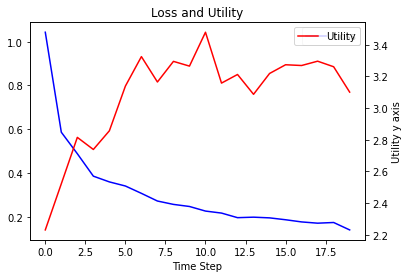

In [29]:
#Training in action
%mkdir model_weights
device=try_gpu()
net=rlPolicy(128, device)
optim1 = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
loss=train(net, train_iter, val_iter, optim1, device, 20, 'DLRL')

In [28]:
def test(net, test_iter, device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)
    U_list=[]
    with torch.no_grad():
        for X, _, _, zp in test_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            U, _=calcUtility(output, zp)
            U_list.append(U[:, -1].mean().cpu().numpy())
    return np.array(U_list).mean()

In [30]:
avgReturn=test(net, test_iter, device, 10, 'DLRL')
print(f'On average, every 20 days the algorithm yields:{avgReturn}' )

On average, every 20 days the algorithm yields:12.865621566772461


In [31]:
def demo(net, demo_iter, device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    device=try_gpu()
    net.to(device)
    with torch.no_grad():
        
        X, zp = torch.tensor(demo_iter[0]).to(device),  torch.tensor(demo_iter[1]).to(device)
        state=net.begin_state(batch_size=X.shape[0], device=device)
        predP, output=net(X, state)
        discretizedAction=((output>=0)*2-1).reshape(-1)
        reward=discretizedAction*zp
        result = [sum(reward[ : i + 1]) for i in range(len(reward))] 
    fig, ax_left = plt.subplots(figsize=(20,4))
    ax_left.plot(result, label = "Stock Gain", color='blue')
    ax_left.set_xlabel('Time Step')
    ax_left.set_ylabel('Cumulative Gain')
    ax_left.set_title('Demonstration of Algorithm')
    ax_left.legend()
    return 

In [32]:
def demoStock(idx, name_list):
    full_list=get_data_set(name_list)
    print(f'Using Stock {name_list[idx]} as demonstration')
    #closing: from id=0 to last
    closing=full_list[idx][:, 3]
    #data from id=0 to second to last
    data=full_list[idx][:-1]
    dataNorm=np.nan_to_num((data-data.mean(axis=0, keepdims=True))/data.std(axis=0, keepdims=True))
    diff=closing[1:]-closing[:-1]
    return dataNorm.astype('float32').reshape(1, -1, 45) , diff.astype('float32')

Using Stock ORCL as demonstration


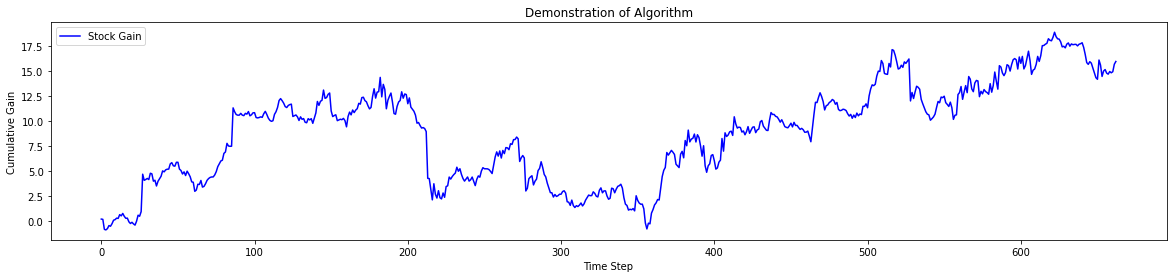

In [34]:
demo_iter=demoStock(5, stockList1)
demo(net, demo_iter , device, 10, 'DLRL')

Using Stock ADBE as demonstration


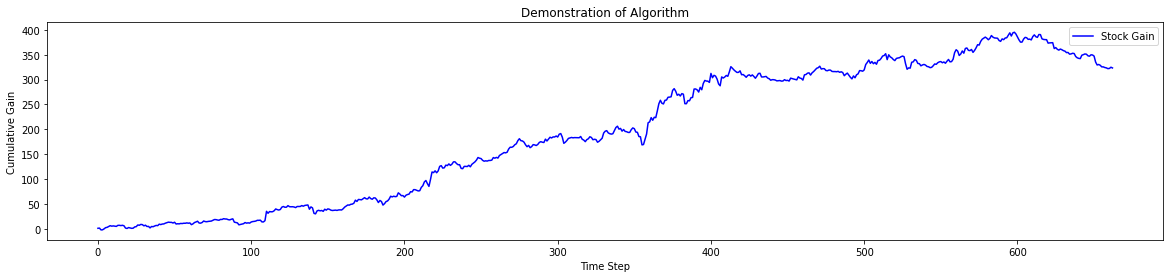

In [35]:
demo_iter=demoStock(6, stockList1)
demo(net, demo_iter , device, 10, 'DLRL')